In [2]:
pip install reverse_geocoder

     ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
     --------- ------------------------------ 0.5/2.2 MB 8.2 MB/s eta 0:00:01
     ---------------------------- ----------- 1.6/2.2 MB 4.2 MB/s eta 0:00:01
     ---------------------------------------- 2.2/2.2 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268126 sha256=f7f206505b23e3eaf7a97615931ec2f081224280a5a0382c8e02954a817787cf
  Stored in directory: c:\users\welcome\appdata\local\pip\cache\wheels\11\e1\67\6e47f0ad41ea1843d37e1fbe79c6074744a1f4aace641cf800
Successfully built reverse_geocoder
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install pycountry

   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.3 MB 5.6 MB/s eta 0:00:02
   ----------- ---------------------------- 1.8/6.3 MB 6.3 MB/s eta 0:00:01
   ------------------ --------------------- 2.9/6.3 MB 5.8 MB/s eta 0:00:01
   -------------------------- ------------- 4.2/6.3 MB 5.6 MB/s eta 0:00:01
   ---------------------------------- ----- 5.5/6.3 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 6.3/6.3 MB 5.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import reverse_geocoder as rg
import pycountry
import time
from tqdm import tqdm

In [11]:
pip install chardet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd
import chardet

# First, let's properly detect and handle the encoding
def read_problematic_csv(filepath):
    # Read a sample to detect encoding
    with open(filepath, 'rb') as f:
        rawdata = f.read(100000)  # Read first 100KB to guess encoding
        result = chardet.detect(rawdata)
    
    print(f"Detected encoding: {result['encoding']} with confidence {result['confidence']}")
    
    # Try reading with detected encoding
    try:
        df = pd.read_csv(filepath, encoding=result['encoding'])
        print("Successfully read with detected encoding")
        return df
    except:
        pass
    
    # If that fails, try common encodings
    encodings_to_try = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252', 'utf-16']
    
    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            print(f"Successfully read with {encoding} encoding")
            return df
        except:
            continue
    
    # If all else fails, use error handling
    print("Couldn't determine encoding, using error handling")
    try:
        df = pd.read_csv(filepath, encoding='utf-8', errors='replace')
        return df
    except:
        raise Exception("Failed to read CSV file with all attempted encodings")

# Read your file
df = read_problematic_csv('Address_dataset.csv')

# Clean column names by stripping whitespace
df.columns = df.columns.str.strip()

# Display first few rows to verify


Detected encoding: ascii with confidence 1.0
Successfully read with latin1 encoding


In [15]:
df.head(100)

,Place Name,Latitude,Longitude
0,"Gudivada, Andhra Pradesh, India",16.441025,80.992630
1,"Dhinoj, Patan, Gujarat, India",23.661324,72.279541
2,"Idappadi, Salem, Tamil Nadu, India",11.580000,77.849998
3,"Chitalwana, Rajasthan, India",24.924999,71.659721
4,"Pugal, Rajasthan, India",28.500000,72.800003
...,...,...,...
95,"Jalalabad, Punjab, India",30.605730,74.256111
96,"Takarwan, Maharashtra, India",19.250380,76.012505
97,"Purena, Raipur, Chhattisgarh, India",21.238678,81.704781
98,"Kailash, Karnal, Haryana, India",29.728127,77.010422


In [16]:
import reverse_geocoder as rg
import pycountry
from tqdm import tqdm
import numpy as np

# Function to extract location components
def extract_components(row):
    try:
        parts = row['Place Name'].split(', ')
        row['City'] = parts[0] if len(parts) > 0 else np.nan
        row['State'] = parts[1] if len(parts) > 1 else np.nan
        row['Country'] = parts[2] if len(parts) > 2 else np.nan
    except:
        row['City'] = np.nan
        row['State'] = np.nan
        row['Country'] = np.nan
    return row

df = df.apply(extract_components, axis=1)

# Validate coordinates with robust error handling
def validate_coordinates(df):
    print("Starting coordinate validation...")
    
    # Initialize new columns
    df['valid_coords'] = False
    df['detected_country'] = np.nan
    df['detected_country_name'] = np.nan
    df['country_match'] = False
    df['is_valid'] = False
    
    # Prepare coordinates for batch processing
    coords = []
    indices = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preparing coordinates"):
        try:
            lat = float(row['Latitude'])
            lon = float(row['Longitude'])
            if -90 <= lat <= 90 and -180 <= lon <= 180:
                df.at[idx, 'valid_coords'] = True
                coords.append((lat, lon))
                indices.append(idx)
        except:
            continue
    
    # Batch reverse geocoding
    if coords:
        print("Performing reverse geocoding...")
        try:
            results = rg.search(coords)
            
            # Process results
            for i, idx in enumerate(indices):
                try:
                    result = results[i]
                    df.at[idx, 'detected_country'] = result['cc']
                    
                    # Get country name
                    try:
                        country_name = pycountry.countries.get(alpha_2=result['cc']).name
                        df.at[idx, 'detected_country_name'] = country_name
                        
                        # Check country match
                        if pd.notna(df.at[idx, 'Country']):
                            df.at[idx, 'country_match'] = (
                                str(df.at[idx, 'Country']).lower() == 
                                str(country_name).lower()
                            )
                    except:
                        continue
                except:
                    continue
        except Exception as e:
            print(f"Error during reverse geocoding: {e}")
    
    # Final validation
    df['is_valid'] = df['valid_coords'] & df['country_match']
    
    return df

# Perform validation
df = validate_coordinates(df)

# Save results
output_file = 'validated_addresses.csv'
df.to_csv(output_file, index=False, encoding='utf-8')
print(f"Validation complete. Results saved to {output_file}")
print("\nValidation Summary:")
print(f"Total addresses: {len(df)}")
print(f"Valid addresses: {df['is_valid'].sum()}")
print(f"Invalid coordinates: {len(df) - df['valid_coords'].sum()}")
print(f"Country mismatches: {df['valid_coords'].sum() - df['country_match'].sum()}")

Starting coordinate validation...


Preparing coordinates: 100%|██████████| 5103/5103 [00:00<00:00, 12022.11it/s]


Performing reverse geocoding...
Loading formatted geocoded file...


C:\Users\Welcome\AppData\Local\Temp\ipykernel_15168\2689380158.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'detected_country'] = result['cc']
C:\Users\Welcome\AppData\Local\Temp\ipykernel_15168\2689380158.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'India' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'detected_country_name'] = country_name


Validation complete. Results saved to validated_addresses.csv

Validation Summary:
Total addresses: 5103
Valid addresses: 4175
Invalid coordinates: 1
Country mismatches: 927


In [24]:
data=pd.read_csv("validated_addresses.csv")

In [25]:
data.head()

,Place Name,Latitude,Longitude,City,State,Country,valid_coords,detected_country,detected_country_name,country_match,is_valid
0,"Gudivada, Andhra Pradesh, India",16.441025,80.992630,Gudivada,Andhra Pradesh,India,True,IN,India,True,True
1,"Dhinoj, Patan, Gujarat, India",23.661324,72.279541,Dhinoj,Patan,Gujarat,True,IN,India,False,False
2,"Idappadi, Salem, Tamil Nadu, India",11.580000,77.849998,Idappadi,Salem,Tamil Nadu,True,IN,India,False,False
3,"Chitalwana, Rajasthan, India",24.924999,71.659721,Chitalwana,Rajasthan,India,True,IN,India,True,True
4,"Pugal, Rajasthan, India",28.500000,72.800003,Pugal,Rajasthan,India,True,PK,Pakistan,False,False


In [26]:
df = pd.DataFrame(data)

In [27]:
print(df)

                                    Place Name   Latitude  Longitude  \
0              Gudivada, Andhra Pradesh, India  16.441025  80.992630   
1                Dhinoj, Patan, Gujarat, India  23.661324  72.279541   
2           Idappadi, Salem, Tamil Nadu, India  11.580000  77.849998   
3                 Chitalwana, Rajasthan, India  24.924999  71.659721   
4                      Pugal, Rajasthan, India  28.500000  72.800003   
...                                        ...        ...        ...   
5098                 Prabhadevi, Mumbai, India  19.016439  72.829422   
5099  Cuffe Parade, Mumbai, Maharashtra, India  18.914042  72.821693   
5100      Punjabi Market, Uttar Pradesh, India  25.894260  81.939079   
5101                            Varthur, India  12.938482  77.747711   
5102          Greenwood Sonata, Kolkata, India  22.622389  88.452339   

                  City           State      Country  valid_coords  \
0             Gudivada  Andhra Pradesh        India          True 

In [30]:
def prepare_features(df):
    """Create features for the model"""
    # Convert boolean to numeric
    df['valid_coords'] = df['valid_coords'].astype(int)
    df['country_match'] = df['country_match'].astype(int)
    
    # Geographic features
    df['abs_latitude'] = df['Latitude'].abs()
    df['distance_from_equator'] = df['abs_latitude']
    df['hemisphere'] = np.where(df['Latitude'] >= 0, 1, 0)  # 1=N, 0=S
    
    # Encode categorical features
    le = LabelEncoder()
    df['state_encoded'] = le.fit_transform(df['State'])
    df['country_encoded'] = le.fit_transform(df['detected_country'])
    
    # Select final features
    features = df[['valid_coords', 'country_match', 'Latitude', 'Longitude',
                  'abs_latitude', 'distance_from_equator', 'hemisphere',
                  'state_encoded', 'country_encoded']]
    
    return features, le


In [31]:
prepare_features(df)

(      valid_coords  country_match   Latitude  Longitude  abs_latitude  \
 0                1              1  16.441025  80.992630     16.441025   
 1                1              0  23.661324  72.279541     23.661324   
 2                1              0  11.580000  77.849998     11.580000   
 3                1              1  24.924999  71.659721     24.924999   
 4                1              0  28.500000  72.800003     28.500000   
 ...            ...            ...        ...        ...           ...   
 5098             1              1  19.016439  72.829422     19.016439   
 5099             1              0  18.914042  72.821693     18.914042   
 5100             1              1  25.894260  81.939079     25.894260   
 5101             1              0  12.938482  77.747711     12.938482   
 5102             1              1  22.622389  88.452339     22.622389   
 
       distance_from_equator  hemisphere  state_encoded  country_encoded  
 0                 16.441025       

In [32]:
X, label_encoder = prepare_features(df)
y = df['is_valid'].astype(int)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training model...")
model.fit(X_train, y_train)

Training model...


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [34]:
from sklearn.metrics import (accuracy_score, classification_report, 
                            confusion_matrix, roc_auc_score)
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nModel Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

evaluate_model(model, X_test, y_test)


Model Evaluation:
Accuracy: 1.00
AUC-ROC: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       186
           1       1.00      1.00      1.00       835

    accuracy                           1.00      1021
   macro avg       1.00      1.00      1.00      1021
weighted avg       1.00      1.00      1.00      1021


Confusion Matrix:
[[186   0]
 [  0 835]]


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv('validated_addresses.csv')

# Drop columns not needed for training
df = df.drop(columns=['Place Name'])

# Encode categorical features
# Drop columns that are direct indicators or duplicates of the label
leaky_cols = ['valid_coords', 'country_match', 'detected_country', 'detected_country_name']
df_clean = df.drop(columns=leaky_cols)

# Encode categorical columns again if needed
label_cols = ['City', 'State', 'Country']
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le

# Features and target
X = df_clean.drop(columns=['is_valid'])  # cleaned features
y = df_clean['is_valid']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9980411361410382

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99       195
        True       1.00      1.00      1.00       826

    accuracy                           1.00      1021
   macro avg       1.00      0.99      1.00      1021
weighted avg       1.00      1.00      1.00      1021



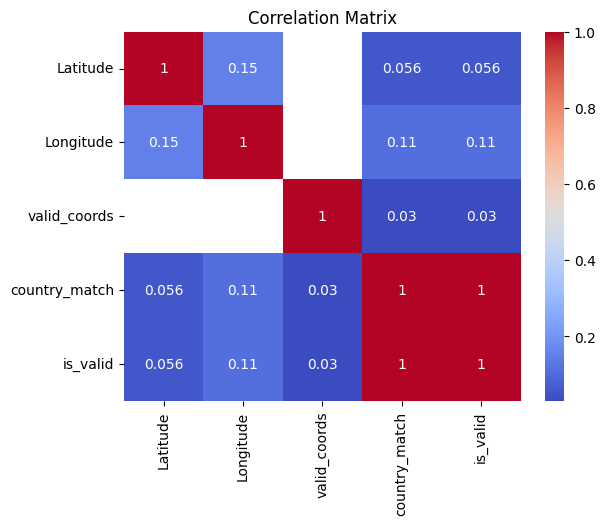

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [5]:
print(df['is_valid'].value_counts())


is_valid
True     4175
False     928
Name: count, dtype: int64


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load data
df = pd.read_csv("validated_addresses.csv")

# Drop leaky columns
df = df.drop(columns=['Place Name', 'valid_coords', 'country_match', 'detected_country', 'detected_country_name'])

# Encode categorical columns
label_cols = ['City', 'State', 'Country']
encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Separate classes
df_true = df[df['is_valid'] == True]
df_false = df[df['is_valid'] == False]

# Undersample majority class (True) to match minority (False)
df_true_sampled = df_true.sample(n=len(df_false), random_state=42)

# Combine to form a balanced dataset
df_balanced = pd.concat([df_true_sampled, df_false], axis=0).sample(frac=1, random_state=42)  # shuffle

# Features and target
X = df_balanced.drop(columns=['is_valid'])
y = df_balanced['is_valid']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Balanced class distribution:\n", y.value_counts())
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Balanced class distribution:
 is_valid
True     928
False    928
Name: count, dtype: int64

Accuracy: 0.9973118279569892

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      1.00       187
        True       0.99      1.00      1.00       185

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372



In [7]:
print(df)

       Latitude  Longitude  City  State  Country  is_valid
0     16.441025  80.992630  1468     20       35      True
1     23.661324  72.279541  1135    372       27     False
2     11.580000  77.849998  1656    424       80     False
3     24.924999  71.659721   915    399       35      True
4     28.500000  72.800003  3566    399       35     False
...         ...        ...   ...    ...      ...       ...
5098  19.016439  72.829422  3547    327       35      True
5099  18.914042  72.821693   953    327       53     False
5100  25.894260  81.939079  3576    488       35      True
5101  12.938482  77.747711  4585    188       91     False
5102  22.622389  88.452339  1465    255       35      True

[5103 rows x 6 columns]


In [9]:
print(X.dtypes)


Latitude     float64
Longitude    float64
City           int64
State          int64
Country        int64
dtype: object


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Load dataset
df = pd.read_csv("validated_addresses.csv")  # change to your actual file

# Encode categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert boolean columns to int
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

# Balance dataset (50-50)
df_majority = df[df['is_valid'] == 1]
df_minority = df[df['is_valid'] == 0]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42)  # Shuffle

# Split features and target
X = df_balanced[['Latitude', 'Longitude', 'City', 'State', 'Country']]
y = df_balanced['is_valid']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train and evaluate each
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [18]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'geopy'